# 分类任务--MNIST数据集

## 获取数据集

In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)

mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [8]:
X,y = mnist["data"], mnist["target"]

In [9]:
X.shape

(70000, 784)

In [10]:
y.shape

(70000,)

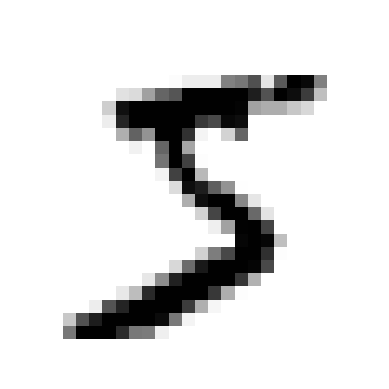

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
# 假设 X 是一个 pandas DataFrame，使用 iloc 访问第一行
some_digit = X.iloc[0].values  # 获取 DataFrame 中的第一行，并转换为 NumPy 数组

# 将一维数组重新塑形为 28x28 的二维数组，以便显示为图像
some_digit_image = some_digit.reshape(28, 28)

# 使用 Matplotlib 显示图像
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [12]:
y[0]

'5'

In [13]:
y = y.astype(np.uint8)

In [14]:
#获取训练集和测试集
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## 训练二元分类器

In [15]:
# 区分5和非5
y_train_5 = (y_train==5)
y_test_5 = (y_test==5)

In [23]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=41)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=41)

In [17]:
sgd_clf.predict([some_digit])

c:\Users\89556\.conda\envs\pydata\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

# 性能测量

## 使用交叉验证测量准确率

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    # 使用 .iloc[] 来选择行
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5.iloc[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.96385
0.9632
0.96505


In [25]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.9566 , 0.95355, 0.96165])

In [26]:
# 创造将所有图分类为非5的分类器

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X),1), dtype=bool)

In [27]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

## 混淆矩阵

In [28]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53651,   928],
       [ 1636,  3785]], dtype=int64)

In [30]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

## 精度和召回率

In [31]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8030978145554848

In [32]:
recall_score(y_train_5, y_train_pred)

0.6982106622394392

In [33]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.74699032958358

## 精度/召回率权衡

In [34]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

c:\Users\89556\.conda\envs\pydata\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([4620.35894938])

In [36]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [37]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [38]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

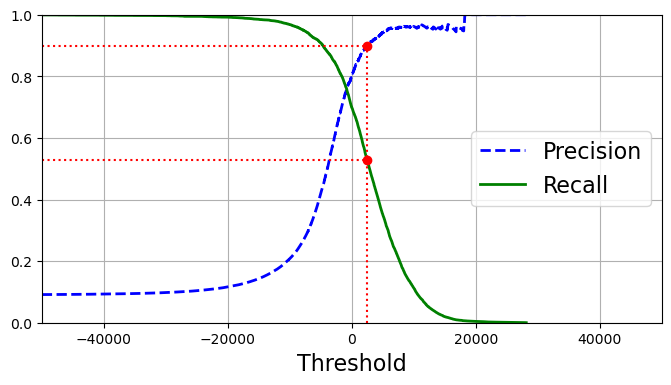

In [48]:
# To plot pretty figures
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) 

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown                                             # Not shown
plt.show()

In [50]:
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

2474.925857757266

In [51]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [52]:
precision_score(y_train_5, y_train_pred_90)

0.9000314366551398

In [53]:
recall_score(y_train_5, y_train_pred_90)

0.5281313410809814

## ROC曲线

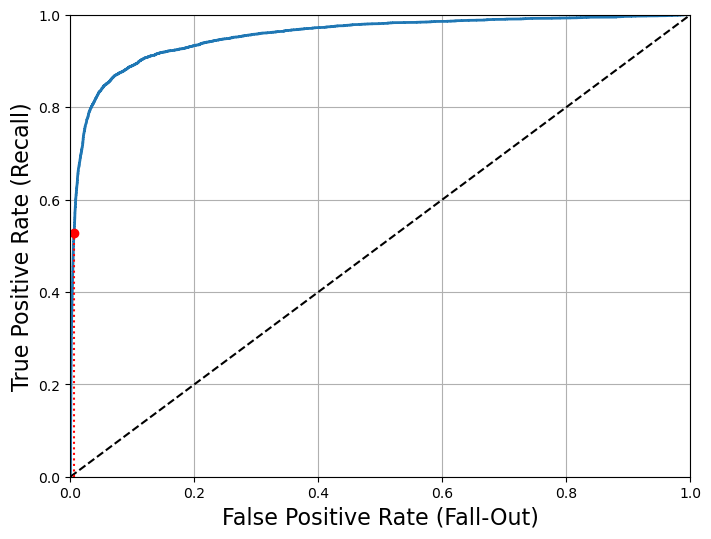

In [56]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown                                  # Not shown
plt.show()

In [57]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9548657434867129

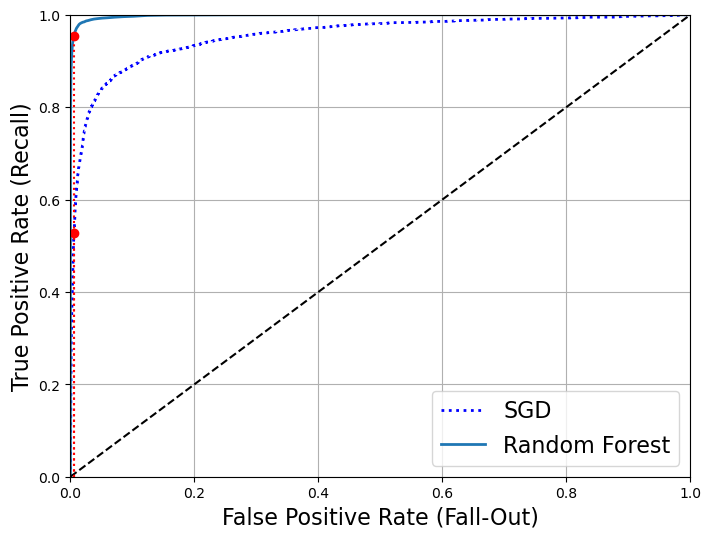

In [58]:
# 使用随机森林模型
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [60]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145